# Bayesian linear regression with `pymc3`

In this post, I'll revisit the [Bayesian linear regression](2018-01-03-bayesian-linreg.ipynb) series, but use [`pymc3`](https://docs.pymc.io).

I'm still a little fuzzy on how `pymc3` things work. Luckily it turns out that `pymc3`'s [getting started tutorial](http://docs.pymc.io/notebooks/getting_started) includes this task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

# helper functions you can skip over :D
SAVE = False
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

/Users/jessica/Documents/notes/venv/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): We are not able to detect the number of CPU cores. We disable openmp by default. To remove this warning, set the environment variable OMP_NUM_THREADS to the number of threads you want theano to use.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data generation

Data generation corresponds to [Bayesian Linear Regression part 2: demo data](2018-01-08-bayesian-linreg-sample.ipynb) (The order of the first two posts of the original series are interchangeable.)

I need to generate observed data to learn from. I'll use the same model as before where the underlying function $f$ is a line:

$$f = mx + b.$$

There's Gaussian noise on the observations, so the observed values are

$$\epsilon \sim \mathcal N(0, \sigma_y)$$
$$y = f + \epsilon.$$

Like the `pymc3` tutorial and my old posts, I'll generate observed data with `numpy`:

In [2]:
N_points = 11

x = 2 * np.random.rand(N_points, 1) - 1

true_sigma_y = 0.1

def f(x):
    return 0.3 * x + 2

noise = true_sigma_y * np.random.randn(x.shape[0], 1)

Y = f(x) + noise

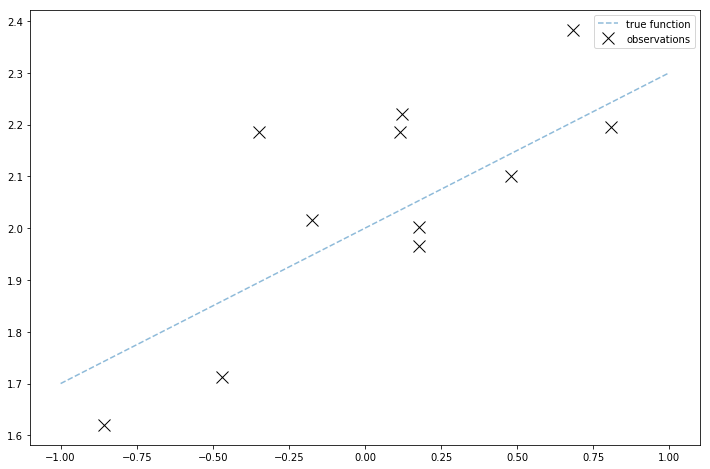

In [3]:
x_grid = np.linspace(-1, 1, 100)[:, None]

plt.figure(figsize=(12, 8))
plt.plot(x_grid, f(x_grid), '--', alpha=0.5, label='true function')
plt.plot(x, f(x) + noise, 'xk', markersize='12', label='observations')
plt.legend()
maybe_save_plot('2018-05-12-simulated-data')
plt.show()

## Sampling from the prior

This part corresponds to [Bayesian Linear Regression part 1: plotting samples from the weight prior](2018-01-03-bayesian-linreg.ipynb).

Now I'll use `pymc3`! To [sample from the weights prior](2018-01-03-bayesian-linreg.ipynb), I need to set up my model. First I'll copy over my hyperparameters from the old post.
(Note: I updated the subscript on the slope from `_w` to `_m`).

In [4]:
# weights on the priors
mu_m = 0
mu_b = 0

sigma_m = 0.2
sigma_b = 0.2

[Before](2018-01-03-bayesian-linreg.ipynb) I sampled weights from the prior using:

    w = np.random.randn(line_count, D) @ V_0 + w_0


Because $V_0$ is a diagonal matrix, this is like sampling from two single-variable Gaussians:

$$w_b \sim \mathcal N(\texttt{mu_b}, \texttt{sigma_b})$$

$$w_m \sim \mathcal N(\texttt{mu_m}, \texttt{sigma_m})$$


In `pymc3`, defining this model and sampling some weights from a model looks like:

In [5]:
mu_w = 0
mu_b = 0

sigma_w = 0.2
sigma_b = 0.2

model = pm.Model()

with model:
    m = pm.Normal('m', mu=mu_m, sd=sigma_m)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b)
    
    prior_trace = pm.sample(200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, m]
100%|██████████| 700/700 [00:01<00:00, 362.92it/s]
Only 200 samples in chain.
Only 200 samples in chain.


There are a few differences so far!

Importantly, by assuming the independence in the priors, `pymc3` is going to learn a model that assumes $w_b$ and $w_m$ are independent. *This is different than the original post*, which also learned a covariance between the two weights.

Aside from the model set up, the action is already a little different! Before I was sampling from the normal distribution using `np.random.randn`, which can be done by sampling from a uniform distribution (a super common operation) and applying a transformation to it to scale it as a Gaussian.

`pymc3` uses fancier sampling approaches (my [last post on Gibbs sampling](2018-05-09-gibbs-sampling.ipynb) is another fancy sampling approach!) This is going to be a common theme in this post: The Gaussian linear regression model I'm using in these posts is a small Gaussian model, which is easy to work with and has a closed-form for its posterior. But this doesn't work in complex models, so `pymc3` uses approximate methods like fancy sampling instead. In other words, I'm using fancy things in `pymc3` that are overkill for my particular model.


### Visualizing

Next I can plot some of the slopes/intercepts sampled from the prior. It looks similar to the plots I got in my [last post](2018-01-03-bayesian-linreg.ipynb).

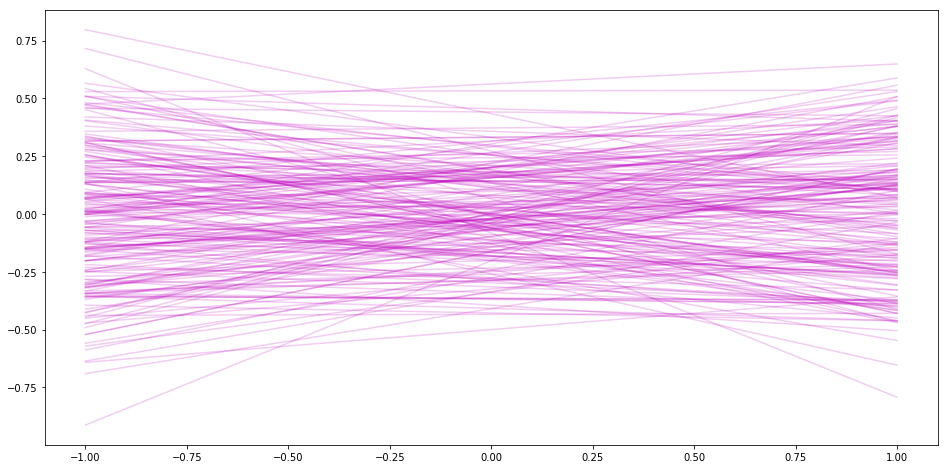

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))

for i in list(prior_trace):
    ax.plot(x_grid, i['m'] * x_grid + i['b'], '-m', alpha=0.2)
maybe_save_plot('2018-05-12-weight-samples')
plt.show()

## Sampling from the Posterior

This part corresponds to [Bayesian Linear Regression part 3: Posterior](2018-01-09-bayesian-linreg-posterior.ipynb) and [Bayesian Linear Regression part 4: Plots](2018-01-10-bayesian-linreg-plots.ipynb).

In the posterior [post](2018-01-09-bayesian-linreg-posterior.ipynb), I had a closed-form for the posterior of a Gaussian likelihood with a Gaussian prior. 

In `pymc3`, I create a deterministic random variable `exp_f` that is $f = mx + b$, where `m` and `b` are the random variables defined above, and `x` are the x-values for the observed data. I set that as the mean of a Normal distribution with the $\sigma_y$ noise (and like the other posts assume I know the true noise `sigma_y = true_sigma_y`.) Then I can pass the observed values `Y` I came up with at the beginning. Then I sample again!

In [7]:
sigma_y = true_sigma_y

# Use the model defined above
with model:
    exp_f = m * x + b
    
    Y_obs = pm.Normal('Y_obs', mu=exp_f, sd=sigma_y, observed=Y)
    
    posterior_trace = pm.sample(200, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, m]
100%|██████████| 1200/1200 [00:10<00:00, 110.19it/s]
Only 200 samples in chain.
Only 200 samples in chain.


Now I can plot a few of these. This is jumping ahead to "Sampling from the posterior" in [Bayesian Linear Regression part 4: Plots](2018-01-10-bayesian-linreg-plots.ipynb). This is another interesting thing about `pymc3` approaches. 
Before, I used the [closed-form of the mean and variance](2018-01-09-bayesian-linreg-posterior.ipynb) of the normal distribution that represents the posterior. Then I sampled from that distribution to plot samples from the posterior.

Using `pymc3`, I skip computing the posterior, and instead use clever methods to sample directly from the posterior. This is useful when the posterior is hard to compute.

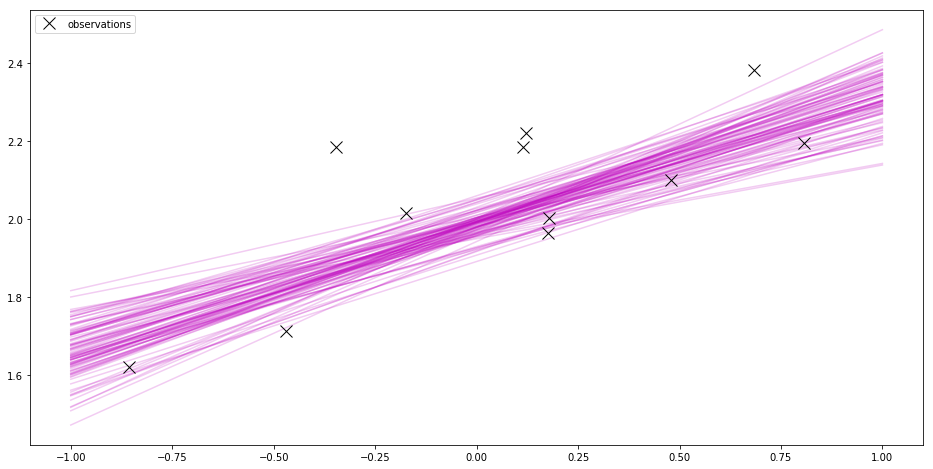

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))

for i in list(posterior_trace[:100]):
    ax.plot(x_grid, i['m'] * x_grid + i['b'], '-m', alpha=0.2)

ax.plot(x, Y, 'xk', markersize='12', label='observations')
plt.legend()
maybe_save_plot('2018-05-12-posterior')
plt.show()

`pymc3` also gives me a cool plot of the samples.

In [9]:
pm.traceplot(posterior_trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1167455c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11788a358>]], dtype=object)

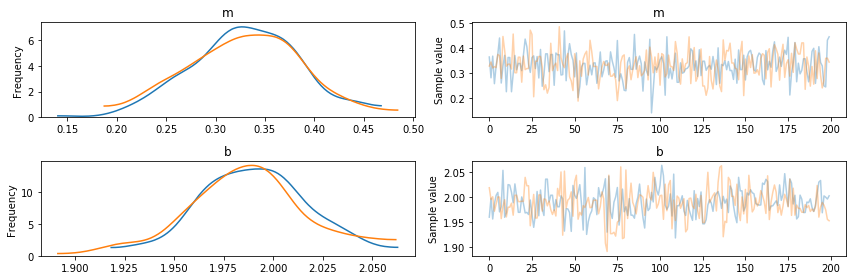

In [10]:
maybe_save_plot('2018-05-12-trace')
plt.show()

## Thoughts: Plotting error

That's all I'm going to post for now. I wasn't able to recreate all of the original series' graphs using `pymc3` yet.

One of my favorite graphs from the series was plotting a shaded area for the uncertainty from [Bayesian Linear Regression part 4: Plots](2018-01-10-bayesian-linreg-plots.ipynb). There are two issues: in this post, I'm assuming the slope and intercept are independent, which is slightly different than that post, and I _think_ that means the uncertainty is incorrectly clumped around 0 (because the form of the function that plots the uncertainty is based on $ax^2 + 2bx + c$, where $b$ is the covariance.) I started using `pm.MvGaussian`, which would find a covariance between the slope and intercept, but `pm.summary(posterior_trace)` gives me separate standard deviations for individual variables. I'll post a follow-up if I can sort this out!